<a href="https://colab.research.google.com/github/DARSHAN-R29/Telco-Customer-Churn-Prediction/blob/main/Telco_Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telco Customer Churn Prediction

In [ ]:
# Install required packages (run once in Colab)
!pip install xgboost shap imbalanced-learn --quiet

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pickle

In [ ]:
column_names = [
    'CustomerID','Gender','SeniorCitizen','Partner','Dependents','Tenure','PhoneService',
    'MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection',
    'TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod',
    'MonthlyCharges','TotalCharges','Churn']

# Update path if different
df = pd.read_csv('/content/telco_clean.csv', header=None, names=column_names)

# Quick cleanup
for col in df.columns:
    df[col] = df[col].astype(str).str.replace(r"\.\d+", "", regex=True)

df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], errors='coerce')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

df['Churn'] = df['Churn'].str.strip().replace({'Yes':1,'No':0}).fillna(0).astype(int)

print(df.head())

   CustomerID  Gender SeniorCitizen Partner Dependents Tenure PhoneService  \
0  7590-VHVEG  Female             0     Yes         No      1           No   
1  5575-GNVDE    Male             0      No         No     34          Yes   
2  3668-QPYBK    Male             0      No         No      2          Yes   
3  7795-CFOCW    Male             0      No         No     45           No   
4  9237-HQITU  Female             0      No         No      2          Yes   

  MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0            \N             DSL             No  ...               No   
1            No             DSL            Yes  ...              Yes   
2            No             DSL            Yes  ...               No   
3            \N             DSL            Yes  ...              Yes   
4            No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No       

/tmp/ipython-input-3664339364.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
/tmp/ipython-input-3664339364.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Churn'] = df['Churn'].str.strip().replace({'Yes':1,'No':0}).f

In [ ]:
# Feature / target
X = df.drop('Churn', axis=1)
y = df['Churn']

categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(exclude=['object']).columns
print('Categorical:', list(categorical_cols))
print('Numeric:', list(numeric_cols))

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

# Train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Fit preprocess and resample
X_train_prep = preprocess.fit_transform(X_train)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_prep, y_train)

print('Resampled shape:', X_train_res.shape)

Categorical: ['CustomerID', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numeric: ['MonthlyCharges', 'TotalCharges']
Resampled shape: (7744, 5391)


In [ ]:
# Train XGBoost
xgb = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, subsample=0.9, colsample_bytree=0.9, use_label_encoder=False, eval_metric='logloss', random_state=42)

xgb.fit(X_train_res, y_train_res)

# Predict
X_test_prep = preprocess.transform(X_test)
pred = xgb.predict(X_test_prep)
prob = xgb.predict_proba(X_test_prep)[:,1]

print('Accuracy:', accuracy_score(y_test, pred))
print('ROC-AUC:', roc_auc_score(y_test, prob))
print(classification_report(y_test, pred))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:30:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7918088737201365
ROC-AUC: 0.8363393747190648
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1291
           1       0.61      0.60      0.61       467

    accuracy                           0.79      1758
   macro avg       0.73      0.73      0.73      1758
weighted avg       0.79      0.79      0.79      1758



<Figure size 1000x800 with 0 Axes>

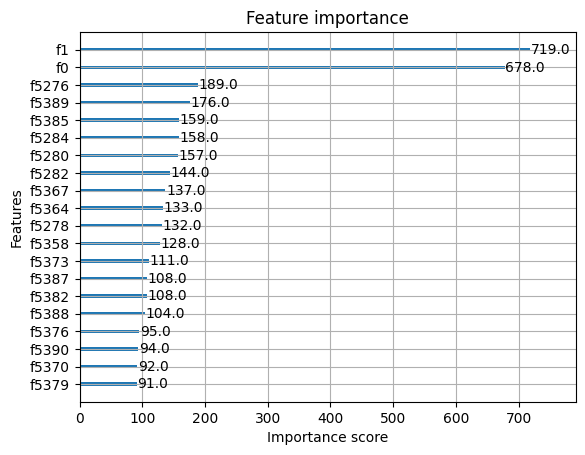

In [ ]:
# Feature importance
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plot_importance(xgb, max_num_features=20)
plt.show()

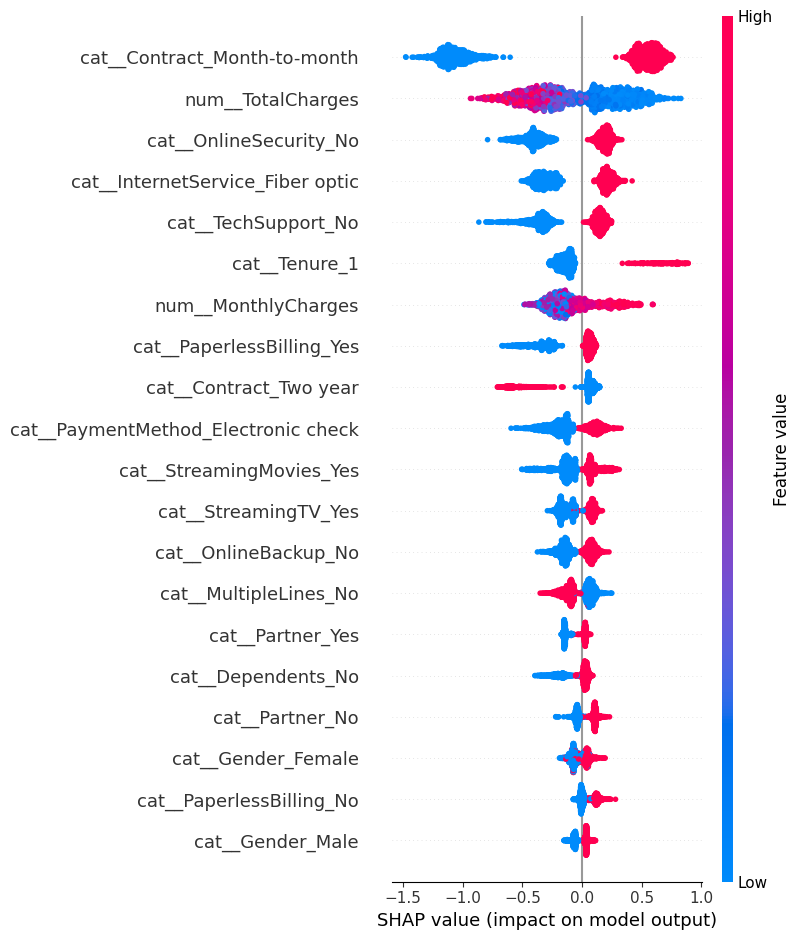

In [ ]:
# SHAP
shap.initjs()
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test_prep)
# summary
shap.summary_plot(shap_values, X_test_prep, feature_names=preprocess.get_feature_names_out())

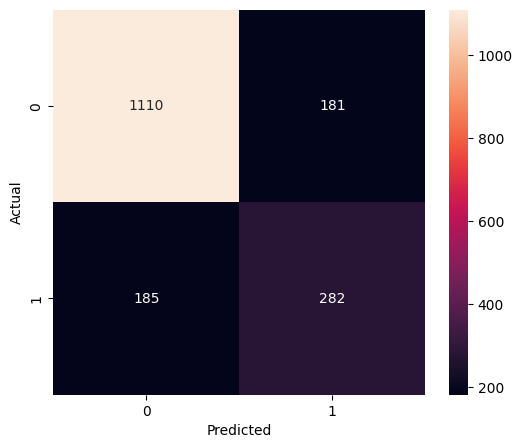

In [ ]:
# Confusion matrix heatmap
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Save model and preprocess
pickle.dump(xgb, open('/content/xgb_churn_model.pkl','wb'))
pickle.dump(preprocess, open('/content/preprocess.pkl','wb'))
print('Saved model and preprocess to /content')

Saved model and preprocess to /content
